# Intrinsic Membrane Properties from Voltage Steps

* Reads in data from the "intrinsic" table of the azure database (requires config.ini file)
* User predefines the groups of interest and the labels to be assigned to those groups
* User can accept the default color scheme (colorblind  safe) or edit according to their preference
* Automatically filters out bad recordings based on input resistance and eliminates duplicates
* Groups the data by mouse strain and calculates descriptive statistics (mean, ste, std) of each field
* Plots the raw data from each group and overlays the mean +/- ste
* Makes an I-V plot and performs a linear fit for each group

### User-Defined Variables

In [9]:
exp_name = 'Shank3'
dir_in = r'D:\Dropbox\Projects\All Olive\Intrinsic\Spreadsheets\200216 - Intrinsic'
f_config = 'config.ini'    # Read in database configuration parameters
groups = ['wt', 'e21_het', 'e13_het', 'e13_ko']
labels = ['WT', 'Shank3C HET', 'Shank3B HET', 'Shank3B KO']

### Imports, Default Variables, and Function Definitions

In [10]:
import pandas as pd
import math
import os
import numpy as np
from IPython.display import display, HTML
from scipy import stats
import matplotlib.pyplot as plt
import pyodbc
import configparser

def get_cm (df_in):
    """Calculates membrane capacitance according to the equation: Cm = Q/V, 
    where Q is the charge (area under the curve) at the specified voltage step (V)"""
    df_temp = df_in.copy()
    df_temp['cm'] = np.nan
    df_temp.cm = df_temp.charge/df_temp.charge_step
    return df_temp

def filter_df (df_in):
    """Filters the data for bad or duplicate recordings and cleans the data from 
    data entry mistakes, irrelevant groups, and noise correction. """
    df_temp = df_in.copy()
    
    # Remove unwanted genotypes
    df_temp = df_temp[df_temp.strain != 'cam_ko']
    df_temp = df_temp[df_temp.strain != 'cam_cre']
    df_temp = df_temp[df_temp.strain != 'tat19']
    df_temp = df_temp[df_temp.strain != 'cam_flox']
    df_temp = df_temp[df_temp.strain != 'cx36']
        
    # Rename genotypes to desired output format
    i = 0
    for group in groups:
        print(i)
        df_temp.strain = np.where(df_temp.strain == group, labels[i], df_temp.strain)
        i = i + 1
    df_temp.ih = np.where(df_temp.ih < 0, 0, df_temp.ih)
    df_temp.cm = np.where(df_temp.cm < 0, -1 * df_temp.cm, df_temp.cm)
    
    # Remove leaky cells
    df_temp = df_temp[df_temp.rinput < 500]
    
    
    # Remove all concentrations of NMDA except 5um
    df_temp = df_temp[df_temp.conc_nmda == 0]
    df_temp = df_temp.drop_duplicates()
    
    return df_temp
 
def save_csv (df_out, file_out, dir_out):
    """Saves the dataframe to a csv spreadsheet in the specified directory. """
    try:
        os.stat(dir_out)
    except:
        os.makedirs(dir_out)

    # Write data to file
    os.chdir(dir_out)
    df_out.to_csv(file_out, index = True)
    
def get_ticks (min_num, max_num):
    """ Calculates the range of data + a 25% buffer to ensure visualization of all datapoints
    and easily readible tick marks."""
    rng = max_num - min_num
    if rng < 1:
        rnd = 2
    elif rng >= 1 and rng < 10:
        rnd = 1
    elif rng >= 10 and rng < 100:
        rnd = -1
    elif rng >=100 and rng < 1000:
        rnd = -2
    elif rng >=1000 and rng < 10000:
        rnd = -3
    half_rng = round (rng, rnd)/2

    tick_min = min_num - half_rng
    tick_max = max_num + half_rng
    return tick_min,tick_max

def plot_desc (fig, ax, col, row, y_scatter, y_mean, y_err, y_title):
    """ Creates a scatter plot of raw data and overlays the mean +/- standard error of the mean."""
    i = 0
    for ys in y_scatter:
        for y in ys:
            ax[row][col].plot ((i + i*np.random.randn(1)*.05), y, ls = 'none', marker = markers[i], markersize = 3, color = colors[i])
        i = i + 1
    
    ax[row][col].plot (x, y_mean, ls = 'none', marker = '_', markersize = 40, color = 'k')
    ax[row][col].errorbar(x, y_mean, y_err, ls = 'none', elinewidth = 3, capsize = 5, color = 'k')
    ax[row][col].set_xlim(-0.5, 3.5)
    y_min = min(y_scatter[1])
    y_max = max (y_scatter[1])
    y_min,y_max = get_ticks(y_min, y_max)
    ax[row][col].set_ylim(y_min, y_max)
    ax[row][col].set_ylabel(y_title, size = 14)
    ax[row][col].tick_params (axis = 'x', labelsize = 10, labelrotation = 90)       
    ax[row][col].spines['top'].set_visible(False)
    ax[row][col].spines['right'].set_visible(False)


### Database Configuration

In [11]:
#  Retrieve MS Azure database connection from config.ini
config = configparser.ConfigParser()
config.read(dir_in + '//' + f_config)
username = config.get('connections', 'DB_USER')
server = config.get('connections', 'DB_HOST')
database = config.get('connections', 'DB_NAME')
password = config.get('connections', 'DB_PWD')
server = config.get('connections','DB_HOST')
driver = config.get('connections', 'DB_DRIVER')

### Import Data from Database

In [12]:
cols = ['filename', 'strain', 'ch', 'conc_nmda', 'charge', 'charge_step', 'cm', 'holding', 'rinput', 'ica', 'ih', 'iahp',
          'h_50', 'h_40','h_30', 'h_20', 'h_10', 'h_0', 'd_10', 'd_20','d_30', 'd_40','d_50', 'd_60']

cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
cursor.execute ("SELECT * FROM intrinsic")
row = cursor.fetchone()

data = []
while row:#
    data.append (list(row))
    row = cursor.fetchone()
df = pd.DataFrame(data, columns = cols)
display(HTML(df.to_html()))    
cursor.close()
cnxn.close()

,filename,strain,ch,conc_nmda,charge,charge_step,cm,holding,rinput,ica,ih,iahp,h_50,h_40,h_30,h_20,h_10,h_0,d_10,d_20,d_30,d_40,d_50,d_60
0,2020_02_11_0002.abf,e21_het,0,0,-292.94800,-10.0,0.034136,2.478645,82.183393,-960.389404,202.059937,-125.428467,-942.722778,-716.569214,-492.891846,-281.501465,-121.679085,2.478645,106.624756,259.006348,458.322144,706.555786,1019.124695,1408.276978
1,2020_02_11_0009.abf,e21_het,0,0,-170.24200,-10.0,0.058740,1.404434,97.035197,-708.132324,104.825989,-74.587402,-698.822571,-541.899414,-376.533203,-223.406403,-103.055389,1.404434,101.192024,212.451172,371.784668,458.624939,719.049683,950.649963
2,2020_02_11_0007.abf,e21_het,0,0,-142.29300,-10.0,0.070278,-1.033932,132.461254,-509.206543,69.031372,-49.611816,-499.502563,-373.893433,-256.882904,-153.810425,-75.493774,-1.033932,72.072144,199.680771,305.996704,390.253876,407.958374,771.871338
3,2020_02_11_0015.abf,e21_het,2,0,-132.39000,-10.0,0.075534,-1.928104,62.191113,-846.796875,69.138794,-45.405273,-839.641724,-681.979980,-447.723999,-270.736053,-160.794678,-1.928104,122.883911,299.673462,319.006958,247.172241,364.820526,573.583984
4,2020_02_13_0008.abf,e21_het,0,0,-290.16100,-10.0,0.034464,6.847530,125.713584,-509.847412,55.799561,48.013916,-505.222168,-376.795044,-250.309448,-167.754501,-79.545898,6.847530,114.919434,270.301514,442.319916,692.333374,799.055176,1059.451904
5,2020_02_14_0004.abf,e21_het,0,0,-68.12120,-20.0,0.293594,-0.867317,422.376901,-122.409660,39.964005,-2.780754,-106.221321,-78.715225,-66.420906,-42.800903,-23.675537,-0.867317,21.025375,53.610237,76.154175,98.433228,119.245605,154.286499
6,2020_02_14_0013.abf,e21_het,2,0,35.53760,-10.0,-0.281392,8.157349,78.222426,-681.710205,10.829468,7.987061,-677.280884,-528.102539,-398.353943,-262.832031,-127.840576,8.157349,125.724487,260.783691,440.992432,578.079224,675.332642,793.541260
7,2020_02_14_0016.abf,e21_het,0,0,-10.32550,-10.0,0.968476,-0.104988,167.062638,-316.660156,-5.648163,15.981430,-316.505188,-254.727798,-193.075562,-126.226212,-59.857788,-0.104988,60.961918,120.613403,177.630005,237.207031,291.930542,348.977051
8,2020_02_14_0024.abf,e21_het,0,0,-86.54700,-10.0,0.115544,-0.827629,64.483881,-857.899170,100.162964,-105.335693,-842.705688,-663.217224,-486.906677,-317.252838,-155.077515,-0.827629,173.793335,372.280884,618.759766,803.081665,1110.300903,1366.714966
9,2020_02_14_0028.abf,e21_het,0,0,-5.41147,-10.0,1.847927,0.396118,164.501295,-278.814667,-10.238037,12.323029,-280.783661,-228.524200,-172.717255,-120.150177,-60.789795,0.396118,49.079010,129.806519,199.014893,275.150757,371.101654,453.779297


### Filter the data and output raw data to file

In [13]:
df = get_cm(df)
df = filter_df(df)
file_out = exp_name + '_intrinsic.csv'
save_csv (df, file_out, dir_in)
display (HTML(df.to_html()))

0
1
2
3


,filename,strain,ch,conc_nmda,charge,charge_step,cm,holding,rinput,ica,ih,iahp,h_50,h_40,h_30,h_20,h_10,h_0,d_10,d_20,d_30,d_40,d_50,d_60
0,2020_02_11_0002.abf,Shank3C HET,0,0,-292.94800,-10.0,29.294800,2.478645,82.183393,-960.389404,202.059937,-125.428467,-942.722778,-716.569214,-492.891846,-281.501465,-121.679085,2.478645,106.624756,259.006348,458.322144,706.555786,1019.124695,1408.276978
1,2020_02_11_0009.abf,Shank3C HET,0,0,-170.24200,-10.0,17.024200,1.404434,97.035197,-708.132324,104.825989,-74.587402,-698.822571,-541.899414,-376.533203,-223.406403,-103.055389,1.404434,101.192024,212.451172,371.784668,458.624939,719.049683,950.649963
2,2020_02_11_0007.abf,Shank3C HET,0,0,-142.29300,-10.0,14.229300,-1.033932,132.461254,-509.206543,69.031372,-49.611816,-499.502563,-373.893433,-256.882904,-153.810425,-75.493774,-1.033932,72.072144,199.680771,305.996704,390.253876,407.958374,771.871338
3,2020_02_11_0015.abf,Shank3C HET,2,0,-132.39000,-10.0,13.239000,-1.928104,62.191113,-846.796875,69.138794,-45.405273,-839.641724,-681.979980,-447.723999,-270.736053,-160.794678,-1.928104,122.883911,299.673462,319.006958,247.172241,364.820526,573.583984
4,2020_02_13_0008.abf,Shank3C HET,0,0,-290.16100,-10.0,29.016100,6.847530,125.713584,-509.847412,55.799561,48.013916,-505.222168,-376.795044,-250.309448,-167.754501,-79.545898,6.847530,114.919434,270.301514,442.319916,692.333374,799.055176,1059.451904
5,2020_02_14_0004.abf,Shank3C HET,0,0,-68.12120,-20.0,3.406060,-0.867317,422.376901,-122.409660,39.964005,-2.780754,-106.221321,-78.715225,-66.420906,-42.800903,-23.675537,-0.867317,21.025375,53.610237,76.154175,98.433228,119.245605,154.286499
6,2020_02_14_0013.abf,Shank3C HET,2,0,35.53760,-10.0,3.553760,8.157349,78.222426,-681.710205,10.829468,7.987061,-677.280884,-528.102539,-398.353943,-262.832031,-127.840576,8.157349,125.724487,260.783691,440.992432,578.079224,675.332642,793.541260
7,2020_02_14_0016.abf,Shank3C HET,0,0,-10.32550,-10.0,1.032550,-0.104988,167.062638,-316.660156,0.000000,15.981430,-316.505188,-254.727798,-193.075562,-126.226212,-59.857788,-0.104988,60.961918,120.613403,177.630005,237.207031,291.930542,348.977051
8,2020_02_14_0024.abf,Shank3C HET,0,0,-86.54700,-10.0,8.654700,-0.827629,64.483881,-857.899170,100.162964,-105.335693,-842.705688,-663.217224,-486.906677,-317.252838,-155.077515,-0.827629,173.793335,372.280884,618.759766,803.081665,1110.300903,1366.714966
9,2020_02_14_0028.abf,Shank3C HET,0,0,-5.41147,-10.0,0.541147,0.396118,164.501295,-278.814667,0.000000,12.323029,-280.783661,-228.524200,-172.717255,-120.150177,-60.789795,0.396118,49.079010,129.806519,199.014893,275.150757,371.101654,453.779297


### Calculate Descriptive Stats 

In [14]:
df_means = df.groupby('strain').mean()
df_se = df.groupby('strain').sem()
df_sd = df.groupby('strain').std()

df_means = df_means.reset_index()
df_se = df_se.reset_index()
df_sd = df_sd.reset_index()

display(HTML('<h4>Means By Group</h4>'))
display (HTML(df_means.to_html()))
display(HTML('<h4>Standard Errors ofthe Mean By Group</h4>'))
display (HTML(df_se.to_html()))
display(HTML('<h4>Standard Deviation ofthe Mean By Group</h4>'))
display (HTML(df_sd.to_html()))

,strain,ch,conc_nmda,charge,charge_step,cm,holding,rinput,ica,ih,iahp,h_50,h_40,h_30,h_20,h_10,h_0,d_10,d_20,d_30,d_40,d_50,d_60
0,Shank3B HET,0.956522,0.0,-189.151247,-11.739130,15.961031,1.143534,178.345617,-898.205077,44.347325,26.371381,-466.741942,-356.220090,-256.530369,-159.619400,-76.100571,1.143534,73.853841,158.191661,251.008800,375.700763,521.417266,689.163563
1,Shank3B KO,1.103448,0.0,-155.322345,-13.448276,11.772842,-0.506654,214.382880,-615.976647,35.979674,8.455095,-369.010702,-291.061067,-215.617656,-138.745117,-66.833474,-0.506654,70.845168,143.348704,241.557492,348.667563,472.088601,618.845536
2,Shank3C HET,0.705882,0.0,-170.526857,-10.588235,17.270419,1.018679,117.148916,-994.763756,55.748227,-21.324821,-636.355887,-495.404177,-358.356677,-231.854572,-113.610771,1.018679,109.826161,252.947925,340.030658,494.233903,668.893063,912.065638
3,WT,0.769231,0.0,-103.526308,-13.076923,9.017105,-0.143898,137.360113,-873.436279,46.710571,-5.891955,-580.252441,-454.279484,-334.734551,-218.677514,-108.124063,-0.143898,106.184040,222.158811,343.031528,457.334779,581.789085,710.683028


,strain,ch,charge,charge_step,cm,conc_nmda,d_10,d_20,d_30,d_40,d_50,d_60,filename,h_0,h_10,h_20,h_30,h_40,h_50,holding,iahp,ica,ih,rinput
0,Shank3B HET,0.212999,28.862199,0.808105,2.363209,0.0,8.844930,20.514150,34.678720,50.400540,70.389283,96.455793,NaN,0.501704,8.180770,17.940508,30.679509,43.703306,58.005518,0.501704,14.033513,308.777173,12.687095,23.046402
1,Shank3B KO,0.187968,23.833515,0.898255,1.734711,0.0,8.881648,19.856127,34.999492,53.239828,77.557519,108.758425,NaN,0.558501,8.361971,18.775334,30.749651,44.356361,57.988166,0.558501,9.949719,202.478779,13.348877,20.638291
2,Shank3C HET,0.238942,41.336124,0.588235,4.061000,0.0,12.253989,27.358343,41.183533,60.189587,83.615864,113.282982,NaN,0.945619,13.655867,27.216572,39.758583,51.366544,65.154882,0.945619,18.113701,272.809002,12.804334,21.094808
3,WT,0.280883,24.216634,1.332347,2.391742,0.0,19.602744,39.886895,61.480112,83.127806,106.262504,130.450719,NaN,0.389155,19.159502,38.785328,58.055288,78.523099,98.472795,0.389155,11.657191,211.454747,18.674822,27.714107


,strain,ch,conc_nmda,charge,charge_step,cm,holding,rinput,ica,ih,iahp,h_50,h_40,h_30,h_20,h_10,h_0,d_10,d_20,d_30,d_40,d_50,d_60
0,Shank3B HET,1.021508,0.0,138.418245,3.875534,11.333553,2.406086,110.526661,1480.843300,60.845168,67.302365,278.184689,209.593691,147.133754,86.039656,39.233592,2.406086,42.418794,98.382407,166.313296,241.712497,337.575141,462.585730
1,Shank3B KO,1.012240,0.0,128.347405,4.837253,9.341702,3.007621,111.140599,1090.381594,71.885904,53.580877,312.275832,238.866316,165.591939,101.108266,45.030591,3.007621,47.829139,106.928514,188.478030,286.705250,417.660023,585.682042
2,Shank3C HET,0.985184,0.0,170.433207,2.425356,16.743930,3.898886,86.976120,1124.820331,52.793620,74.684701,268.640460,211.789687,163.928835,112.216802,56.304583,3.898886,50.524489,112.801339,169.804055,248.168023,344.757039,467.077702
3,WT,1.012739,0.0,87.314314,4.803845,8.623549,1.403120,99.924633,762.410933,67.333027,42.030600,355.048712,283.119059,209.321319,139.842488,69.080567,1.403120,70.678699,143.814246,221.669695,299.721567,383.134908,470.346757


### Plot the summarized data

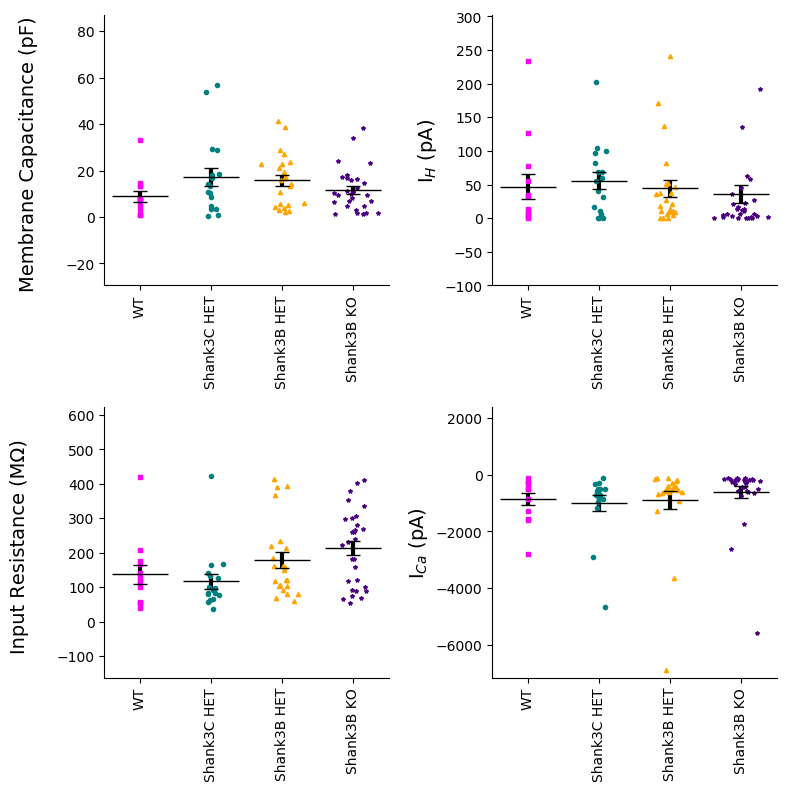

In [15]:
fig, ax = plt.subplots(2,2, figsize = (8,8), dpi = 100)

x = labels
y_titles = ["Membrane Capacitance (pF) \n", "Input Resistance (M\u03A9) \n", "I" + r'$_H$' + " (pA)", 
            "I" + r'$_{Ca}$' + " (pA)"]
colors = ['magenta','teal','orange', 'indigo']
markers = ['s', 'o', '^', '*']

# Plot Membrane Capacitance
y_cms = [df.cm[df.strain == labels[0]], df.cm[df.strain == labels[1]], df.cm[df.strain == labels[2]], 
         df.cm[df.strain == labels[3]]]
y_cm = [float(df_means.cm[df_means.strain == 'WT']), float(df_means.cm[df_means.strain == 'Shank3C HET']),
        float(df_means.cm[df_means.strain == 'Shank3B HET']), float(df_means.cm[df_means.strain == 'Shank3B KO'])]
y_cm_err = [float(df_se.cm[df_se.strain == 'WT']), float(df_se.cm[df_se.strain == 'Shank3C HET']),
        float(df_se.cm[df_se.strain == 'Shank3B HET']), float(df_se.cm[df_se.strain == 'Shank3B KO'])]
plot_desc(fig, ax, 0, 0, y_cms, y_cm,y_cm_err, y_titles[0])

# Plot Input Resistance
y_rins = [df.rinput[df.strain == labels[0]], df.rinput[df.strain == labels[1]], df.rinput[df.strain == labels[2]], 
         df.rinput[df.strain == labels[3]]]
y_rin = [float(df_means.rinput[df_means.strain == 'WT']), float(df_means.rinput[df_means.strain == 'Shank3C HET']),
        float(df_means.rinput[df_means.strain == 'Shank3B HET']), float(df_means.rinput[df_means.strain == 'Shank3B KO'])]
y_rin_err = [float(df_se.rinput[df_se.strain == 'WT']), float(df_se.rinput[df_se.strain == 'Shank3C HET']),
        float(df_se.rinput[df_se.strain == 'Shank3B HET']), float(df_se.rinput[df_se.strain == 'Shank3B KO'])]
plot_desc(fig, ax, 0, 1, y_rins, y_rin, y_rin_err, y_titles[1])

# Plot the Ih current
y_ihs = [df.ih[df.strain == labels[0]], df.ih[df.strain == labels[1]], df.ih[df.strain == labels[2]], 
         df.ih[df.strain == labels[3]]]
y_ih = [float(df_means.ih[df_means.strain == 'WT']), float(df_means.ih[df_means.strain == 'Shank3C HET']),
        float(df_means.ih[df_means.strain == 'Shank3B HET']), float(df_means.ih[df_means.strain == 'Shank3B KO'])]
y_ih_err = [float(df_se.ih[df_se.strain == 'WT']), float(df_se.ih[df_se.strain == 'Shank3C HET']),
        float(df_se.ih[df_se.strain == 'Shank3B HET']), float(df_se.ih[df_se.strain == 'Shank3B KO'])]
plot_desc(fig, ax, 1, 0, y_ihs, y_ih, y_ih_err, y_titles[2])


# Plot the T-type Calcium Current
y_icas = [df.ica[df.strain == labels[0]], df.ica[df.strain == labels[1]], df.ica[df.strain == labels[2]], 
         df.ica[df.strain == labels[3]]]
y_ica = [float(df_means.ica[df_means.strain == 'WT']), float(df_means.ica[df_means.strain == 'Shank3C HET']),
        float(df_means.ica[df_means.strain == 'Shank3B HET']), float(df_means.ica[df_means.strain == 'Shank3B KO'])]
y_ica_err = [float(df_se.ica[df_se.strain == 'WT']), float(df_se.ica[df_se.strain == 'Shank3C HET']),
        float(df_se.ica[df_se.strain == 'Shank3B HET']), float(df_se.ica[df_se.strain == 'Shank3B KO'])]
plot_desc(fig, ax, 1, 1, y_icas, y_ica, y_ica_err, y_titles[3])

plt.tight_layout()



### Make I-V Plot

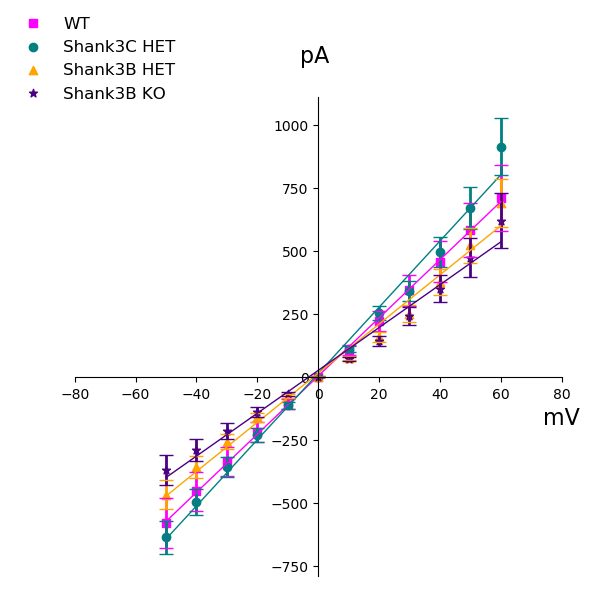

In [16]:


def iv_plot (fig, ax, x, y, y_err, counter, label):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        
    ax = plt.gca()  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))
    
    # Plot the data
    ax.scatter(x, y, marker = markers[counter], color = colors[counter], label = label)  
    ax.errorbar(x, y, y_err, ls = 'none', elinewidth = 2, capsize = 5, color = colors[counter])
    line = [i * slope + intercept for i in x]
    ax.plot (x, line, lw = 1, color = colors[counter])
        #ax.axis ([x_min, x_max, y_min, y_max]) 
        
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, frameon = False, loc='upper left', bbox_to_anchor=(-.15, 1.2), shadow=True, fontsize = 12)
    ax.set_xlim (-80, 80)
    ax.set_title("pA \n", fontsize = 16)
    ax.set_xlabel("mV", fontsize = 16, position = (1,1))
    plt.tight_layout()

# Initiate the figure
fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)    
x = [-50,-40,-30, -20, -10, 0, 10, 20, 30, 40, 50, 60]

i = 0
for label in labels:
    y = [float(df_means.h_50[df_means.strain == label]), 
        float(df_means.h_40[df_means.strain == label]), 
        float(df_means.h_30[df_means.strain == label]), 
        float(df_means.h_20[df_means.strain == label]), 
        float(df_means.h_10[df_means.strain == label]), 
        float(df_means.h_0[df_means.strain == label]), 
        float(df_means.d_10[df_means.strain == label]), 
        float(df_means.d_20[df_means.strain == label]), 
        float(df_means.d_30[df_means.strain == label]), 
        float(df_means.d_40[df_means.strain == label]), 
        float(df_means.d_50[df_means.strain == label]), 
        float(df_means.d_60[df_means.strain == label])]
    y_err = [float(df_se.h_50[df_means.strain == label]), 
        float(df_se.h_40[df_se.strain == label]), 
        float(df_se.h_30[df_se.strain == label]), 
        float(df_se.h_20[df_se.strain == label]), 
        float(df_se.h_10[df_se.strain == label]), 
        float(df_se.h_0[df_se.strain == label]), 
        float(df_se.d_10[df_se.strain == label]), 
        float(df_se.d_20[df_se.strain == label]), 
        float(df_se.d_30[df_se.strain == label]), 
        float(df_se.d_40[df_se.strain == label]), 
        float(df_se.d_50[df_se.strain == label]), 
        float(df_se.d_60[df_se.strain == label])]
    
    iv_plot(fig, ax, x, y , y_err, i, label)
    i = i + 1